# FIS Project 1 
 Lesly Perlaza - 441675

### __MSR decompression__

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import decompress_msr, conjugate_gradient, GetKrylov, make_system, msr_to_matrix

The matrix 1 is symmetric.
The matrix 2 is symmetric.


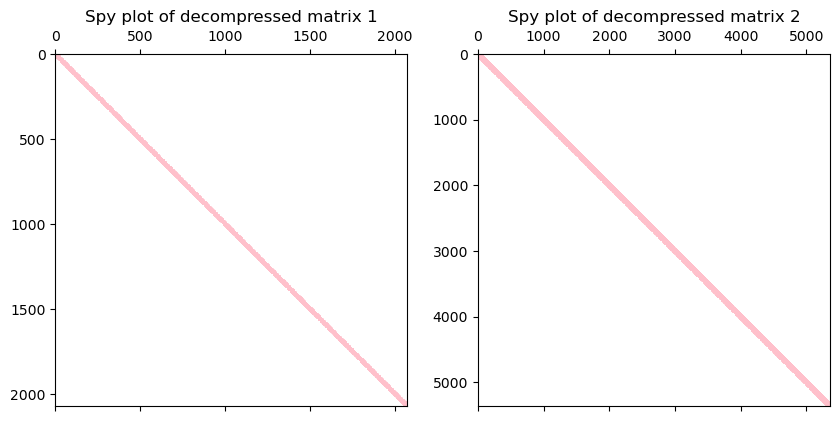

In [25]:
filename = "Data_P1/cg_matrix_msr_1.txt";filename2 = "Data_P1/cg_matrix_msr_2.txt" #Testing MSR format
decompressed_matrix= msr_to_matrix(filename); decompressed_matrix2= msr_to_matrix(filename2)
u = 1
plt.figure(figsize=(10, 10))
for matrix in [decompressed_matrix, decompressed_matrix2]:  # check if the matrix is symmetric
    if np.allclose(matrix, matrix.T):
        print(f"The matrix {u} is symmetric.")
    plt.subplot(1, 2, u)
    plt.spy(matrix, markersize=1, color='pink')
    plt.title(f"Spy plot of decompressed matrix {u}")
    u += 1


### __CG implementation__

In [26]:
A,b,x_true,x0 = make_system(decompressed_matrix) # 1. Create the system of equations
x_approx, residuals, e_A_norms = conjugate_gradient(decompressed_matrix, b, x0, x_true) # 2. Run CG method

In [28]:
A2,b2,x_true2,x02 = make_system(decompressed_matrix2) # 1. Create the system of equations
x_approx2, residuals2, e_A_norms2 = conjugate_gradient(decompressed_matrix2, b2, x02, x_true2) # 2. Run CG method

 MATRIX 1: 
 Shape of Matrix A: (2073, 2073)
Number of iterations: 2074
Final residual norm: 1651.569174038211
Final A-norm error: 12.089633780678195
Final solution x: [1.00000141 1.0843761  1.22963985 ... 1.0008632  0.99435947 0.00126121] 
 
 MATRIX 2: 
Shape of Matrix A: (5364, 5364)
Number of iterations: 5365
Final residual norm: 352.0230480421034
Final A-norm error: 0.6312185155647686
Final solution x: [0.9999872  1.00004719 1.00001545 ... 0.99886273 0.99940757 1.00013499]


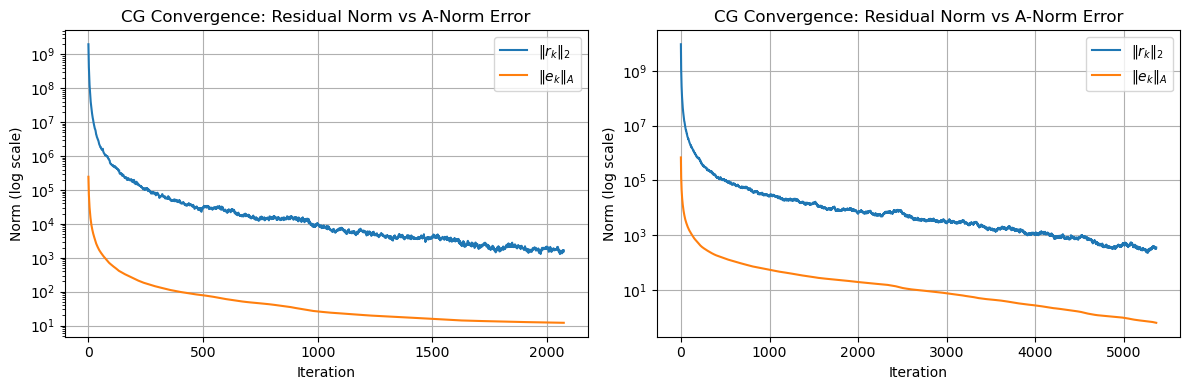

In [37]:
# Plotting and printing results
print(f" MATRIX 1: \n Shape of Matrix A: {decompressed_matrix.shape}"),print(f"Number of iterations: {len(residuals)}"),print(f"Final residual norm: {residuals[-1]}")
print(f"Final A-norm error: {e_A_norms[-1]}"),print(f"Final solution x: {x_approx} \n ")


print(f" MATRIX 2: \nShape of Matrix A: {decompressed_matrix2.shape}")
print(f"Number of iterations: {len(residuals2)}")
print(f"Final residual norm: {residuals2[-1]}")
print(f"Final A-norm error: {e_A_norms2[-1]}")
print(f"Final solution x: {x_approx2}")

u = 1
plt.figure(figsize=(12, 4))
for res in [residuals, residuals2]:  # check if the matrix is symmetric
    plt.subplot(1, 2, u)
    plt.semilogy(res, label=r'$\|r_k\|_2$')
    plt.xlabel('Iteration'), plt.ylabel('Norm (log scale)'), plt.title('CG Convergence: Residual Norm vs A-Norm Error')
    plt.legend(), plt.grid(True), plt.tight_layout()
    u += 1
u = 1
for Ares in [e_A_norms, e_A_norms2]:
    plt.subplot(1, 2, u)
    plt.semilogy(Ares, label=r'$\|e_k\|_A$')
    plt.xlabel('Iteration'), plt.ylabel('Norm (log scale)'), plt.title('CG Convergence: Residual Norm vs A-Norm Error')
    plt.legend(), plt.grid(True), plt.tight_layout()
    u += 1


### __GMRES__

In [8]:
def gmres_borrow(A, b, x0=None, *, tol=1e-8, restart=None, maxiter=None, M=None,
          callback=None, restrt=None, atol=0., callback_type=None,
          rtol=1e-5):
    """
    Use Generalized Minimal RESidual iteration to solve ``Ax = b``.

    Parameters
    ----------
    A : {sparse matrix, ndarray, LinearOperator}
        The real or complex N-by-N matrix of the linear system.
        Alternatively, ``A`` can be a linear operator which can
        produce ``Ax`` using, e.g.,
        ``scipy.sparse.linalg.LinearOperator``.
    b : ndarray
        Right hand side of the linear system. Has shape (N,) or (N,1).
    x0 : ndarray
        Starting guess for the solution (a vector of zeros by default).
    atol, rtol : float
        Parameters for the convergence test. For convergence,
        ``norm(b - A @ x) <= max(rtol*norm(b), atol)`` should be satisfied.
        The default is ``atol=0.`` and ``rtol=1e-5``.
    restart : int, optional
        Number of iterations between restarts. Larger values increase
        iteration cost, but may be necessary for convergence.
        If omitted, ``min(20, n)`` is used.
    maxiter : int, optional
        Maximum number of iterations (restart cycles).  Iteration will stop
        after maxiter steps even if the specified tolerance has not been
        achieved. See `callback_type`.
    M : {sparse matrix, ndarray, LinearOperator}
        Inverse of the preconditioner of A.  M should approximate the
        inverse of A and be easy to solve for (see Notes).  Effective
        preconditioning dramatically improves the rate of convergence,
        which implies that fewer iterations are needed to reach a given
        error tolerance.  By default, no preconditioner is used.
        In this implementation, left preconditioning is used,
        and the preconditioned residual is minimized. However, the final
        convergence is tested with respect to the ``b - A @ x`` residual.
    callback : function
        User-supplied function to call after each iteration.  It is called
        as `callback(args)`, where `args` are selected by `callback_type`.
    callback_type : {'x', 'pr_norm', 'legacy'}, optional
        Callback function argument requested:
          - ``x``: current iterate (ndarray), called on every restart
          - ``pr_norm``: relative (preconditioned) residual norm (float),
            called on every inner iteration
          - ``legacy`` (default): same as ``pr_norm``, but also changes the
            meaning of `maxiter` to count inner iterations instead of restart
            cycles.

        This keyword has no effect if `callback` is not set.
    restrt : int, optional, deprecated

        .. deprecated:: 0.11.0
           `gmres` keyword argument ``restrt`` is deprecated in favor of
           ``restart`` and will be removed in SciPy 1.14.0.
    tol : float, optional, deprecated

        .. deprecated:: 1.12.0
           `gmres` keyword argument ``tol`` is deprecated in favor of ``rtol``
           and will be removed in SciPy 1.14.0

    Returns
    -------
    x : ndarray
        The converged solution.
    info : int
        Provides convergence information:
            0  : successful exit
            >0 : convergence to tolerance not achieved, number of iterations

    See Also
    --------
    LinearOperator

    Notes
    -----
    A preconditioner, P, is chosen such that P is close to A but easy to solve
    for. The preconditioner parameter required by this routine is
    ``M = P^-1``. The inverse should preferably not be calculated
    explicitly.  Rather, use the following template to produce M::

      # Construct a linear operator that computes P^-1 @ x.
      import scipy.sparse.linalg as spla
      M_x = lambda x: spla.spsolve(P, x)
      M = spla.LinearOperator((n, n), M_x)

    Examples
    --------
    >>> import numpy as np
    >>> from scipy.sparse import csc_matrix
    >>> from scipy.sparse.linalg import gmres
    >>> A = csc_matrix([[3, 2, 0], [1, -1, 0], [0, 5, 1]], dtype=float)
    >>> b = np.array([2, 4, -1], dtype=float)
    >>> x, exitCode = gmres(A, b, atol=1e-5)
    >>> print(exitCode)            # 0 indicates successful convergence
    0
    >>> np.allclose(A.dot(x), b)
    True
    """

    # Handle the deprecation frenzy
    if restrt not in (None, _NoValue) and restart:
        raise ValueError("Cannot specify both 'restart' and 'restrt'"
                         " keywords. Also 'rstrt' is deprecated."
                         " and will be removed in SciPy 1.14.0. Use "
                         "'restart' instead.")
    if restrt is not _NoValue:
        msg = ("'gmres' keyword argument 'restrt' is deprecated "
               "in favor of 'restart' and will be removed in SciPy"
               " 1.14.0. Until then, if set, 'rstrt' will override 'restart'."
               )
        restart = restrt

    if callback is not None and callback_type is None:
        # Warn about 'callback_type' semantic changes.
        # Probably should be removed only in far future, Scipy 2.0 or so.
        msg = ("scipy.sparse.linalg.gmres called without specifying "
               "`callback_type`. The default value will be changed in"
               " a future release. For compatibility, specify a value "
               "for `callback_type` explicitly, e.g., "
               "``gmres(..., callback_type='pr_norm')``, or to retain the "
               "old behavior ``gmres(..., callback_type='legacy')``"
               )

    if callback_type is None:
        callback_type = 'legacy'

    if callback_type not in ('x', 'pr_norm', 'legacy'):
        raise ValueError(f"Unknown callback_type: {callback_type!r}")

    if callback is None:
        callback_type = None

    A, M, x, b, postprocess = make_system(A, M, x0, b)
    matvec = A.matvec
    psolve = M.matvec
    n = len(b)
    bnrm2 = np.linalg.norm(b)

    atol, _ = _get_atol_rtol('gmres', bnrm2, tol, atol, rtol)

    if bnrm2 == 0:
        return postprocess(b), 0

    eps = np.finfo(x.dtype.char).eps

    dotprod = np.vdot if np.iscomplexobj(x) else np.dot

    if maxiter is None:
        maxiter = n*10

    if restart is None:
        restart = 20
    restart = min(restart, n)

    Mb_nrm2 = np.linalg.norm(psolve(b))

    # ====================================================
    # =========== Tolerance control from gh-8400 =========
    # ====================================================
    # Tolerance passed to GMRESREVCOM applies to the inner
    # iteration and deals with the left-preconditioned
    # residual.
    ptol_max_factor = 1.
    ptol = Mb_nrm2 * min(ptol_max_factor, atol / bnrm2)
    presid = 0.
    # ====================================================
    lartg = get_lapack_funcs('lartg', dtype=x.dtype)

    # allocate internal variables
    v = np.empty([restart+1, n], dtype=x.dtype)
    h = np.zeros([restart, restart+1], dtype=x.dtype)
    givens = np.zeros([restart, 2], dtype=x.dtype)

    # legacy iteration count
    inner_iter = 0

    for iteration in range(maxiter):
        if iteration == 0:
            r = b - matvec(x) if x.any() else b.copy()
            if np.linalg.norm(r) < atol:  # Are we done?
                return postprocess(x), 0

        v[0, :] = psolve(r)
        tmp = np.linalg.norm(v[0, :])
        v[0, :] *= (1 / tmp)
        # RHS of the Hessenberg problem
        S = np.zeros(restart+1, dtype=x.dtype)
        S[0] = tmp

        breakdown = False
        for col in range(restart):
            av = matvec(v[col, :])
            w = psolve(av)

            # Modified Gram-Schmidt
            h0 = np.linalg.norm(w)
            for k in range(col+1):
                tmp = dotprod(v[k, :], w)
                h[col, k] = tmp
                w -= tmp*v[k, :]

            h1 = np.linalg.norm(w)
            h[col, col + 1] = h1
            v[col + 1, :] = w[:]

            # Exact solution indicator
            if h1 <= eps*h0:
                h[col, col + 1] = 0
                breakdown = True
            else:
                v[col + 1, :] *= (1 / h1)

            # apply past Givens rotations to current h column
            for k in range(col):
                c, s = givens[k, 0], givens[k, 1]
                n0, n1 = h[col, [k, k+1]]
                h[col, [k, k + 1]] = [c*n0 + s*n1, -s.conj()*n0 + c*n1]

            # get and apply current rotation to h and S
            c, s, mag = lartg(h[col, col], h[col, col+1])
            givens[col, :] = [c, s]
            h[col, [col, col+1]] = mag, 0

            # S[col+1] component is always 0
            tmp = -np.conjugate(s)*S[col]
            S[[col, col + 1]] = [c*S[col], tmp]
            presid = np.abs(tmp)
            inner_iter += 1

            if callback_type in ('legacy', 'pr_norm'):
                callback(presid / bnrm2)
            # Legacy behavior
            if callback_type == 'legacy' and inner_iter == maxiter:
                break
            if presid <= ptol or breakdown:
                break

        # Solve h(col, col) upper triangular system and allow pseudo-solve
        # singular cases as in (but without the f2py copies):
        # y = trsv(h[:col+1, :col+1].T, S[:col+1])

        if h[col, col] == 0:
            S[col] = 0

        y = np.zeros([col+1], dtype=x.dtype)
        y[:] = S[:col+1]
        for k in range(col, 0, -1):
            if y[k] != 0:
                y[k] /= h[k, k]
                tmp = y[k]
                y[:k] -= tmp*h[k, :k]
        if y[0] != 0:
            y[0] /= h[0, 0]

        x += y @ v[:col+1, :]

        r = b - matvec(x)
        rnorm = np.linalg.norm(r)

        # Legacy exit
        if callback_type == 'legacy' and inner_iter == maxiter:
            return postprocess(x), 0 if rnorm <= atol else maxiter

        if callback_type == 'x':
            callback(x)

        if rnorm <= atol:
            break
        elif breakdown:
            # Reached breakdown (= exact solution), but the external
            # tolerance check failed. Bail out with failure.
            break
        elif presid <= ptol:
            # Inner loop passed but outer didn't
            ptol_max_factor = max(eps, 0.25 * ptol_max_factor)
        else:
            ptol_max_factor = min(1.0, 1.5 * ptol_max_factor)

        ptol = presid * min(ptol_max_factor, atol / rnorm)

    info = 0 if (rnorm <= atol) else maxiter
    return postprocess(x), info

Text(0.5, 1.0, 'Spy plot of Krylov H matrix')

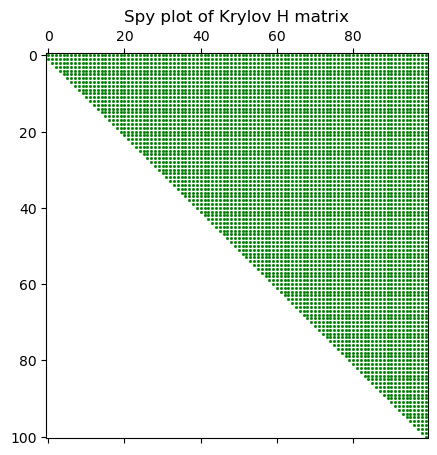

In [ ]:
# Testing Get Krylov
Krylov_V, Krylov_H = GetKrylov(decompressed_matrix, x_true, 100)
plt.figure(figsize=(5, 5))
plt.spy(Krylov_H, markersize=1, color='green')
plt.title("Spy plot of Krylov H matrix")

In [ ]:
filename = "Data_P1/cg_matrix_msr_1.txt"
decompressed_matrix= decompress_msr(filename)

## __Utils__